In [15]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
import mpl_toolkits as mpltk
from geopy.distance import vincenty
import cartopy.crs as ccrs

In [16]:
data_srs_no_null = pd.read_csv('../data/PeMS/Series/light/d07_text_station_5min_2017_10_11.csv', parse_dates=[0])

In [17]:
data_srs_no_null_04 = pd.read_csv('../data/PeMS/Series/light/d07_text_station_5min_2017_10_04.csv', parse_dates=[0])

In [18]:
data_srs_smoothed = pd.read_csv('../data/PeMS/Series/smoothed/d07_text_station_5min_2017_10_11.csv', parse_dates=[0])

In [19]:
data_srs_smoothed_04 = pd.read_csv('../data/PeMS/Series/smoothed/d07_text_station_5min_2017_10_04.csv', parse_dates=[0])

In [20]:
data_inc_d07 = pd.read_csv('../data/PeMS/Incidents/light/all_text_chp_incident_day_2017_10_11.csv', parse_dates=[3])

In [21]:
data_inc_04_d07 = pd.read_csv('../data/PeMS/Incidents/light/all_text_chp_incident_day_2017_10_04.csv', parse_dates=[3])

In [22]:
data_det_inc_07 = pd.read_csv('../data/PeMS/Incidents/light/all_text_chp_incident_det_day_2017_10_11.csv', parse_dates=[2])

In [340]:
stations_active = pd.read_csv('../data/PeMS/Stations/light/d07_text_meta_2017_09_20_active.csv')

In [24]:
def drop_nulls_column(data, c_name):
    return data.dropna(subset=[c_name])

In [25]:
def plot_flow_w_incidents(flow_data, incdnt_data, frw_no, station_no, chrstc_to_plot = 'Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=2017, month=10, day=11, hour=8)
    datemax = dt.datetime(year=2017, month=10, day=11, hour=20)
    data_srs_no_null = flow_data.dropna(subset=[chrstc_to_plot])
    data_incdnts_by_frw = incdnt_data[incdnt_data['Freeway']==frw_no]
    dates = data_srs_no_null[(data_srs_no_null['Freeway'] == frw_no) & (data_srs_no_null['Station'] == station_no)]['Timestamp']
    speed = data_srs_no_null[(data_srs_no_null['Freeway'] == frw_no) & (data_srs_no_null['Station'] == station_no)][chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for x in data_incdnts_by_frw['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

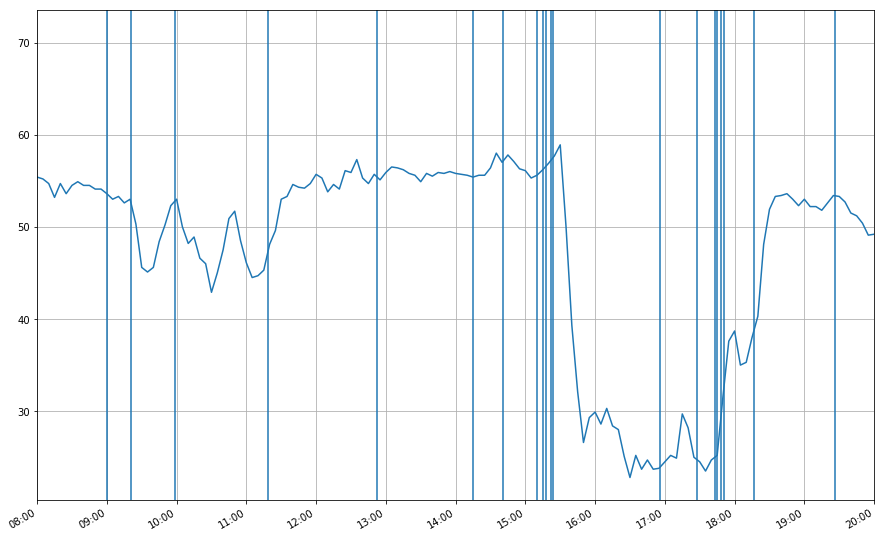

In [26]:
plot_flow_w_incidents(data_srs_no_null, data_inc_d07, 101, 716328)

In [27]:
def show_unique_freeways(data):
#     result = np.empty([0,len(data.columns)])
    maximum=0
    for st in data['Station'].unique():
#         result = np.append(result, data[data['Station'] == st])
        crnt_len = len(data[data['Station'] == st]['Freeway'].unique())
        if crnt_len > maximum:
            maximum = crnt_len
    return maximum

In [28]:
print(show_unique_freeways(data_srs_no_null))

1


In [29]:
min_lon = stations_active['Longitude'].min()
max_lon = stations_active['Longitude'].max()
min_lat = stations_active['Latitude'].min()
max_lat = stations_active['Latitude'].max()

In [30]:
st1_coords = (stations_active['Latitude'][0], stations_active['Longitude'][0])
st2_coords = (stations_active['Latitude'][1], stations_active['Longitude'][1])
st1_coords_ccrs = [stations_active['Latitude'][0], stations_active['Longitude'][0]]

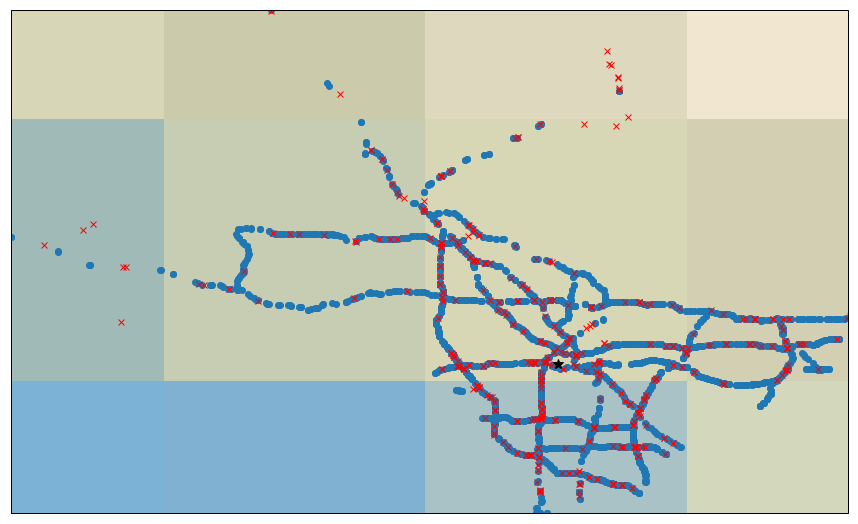

In [33]:
fig = plt.figure(figsize=[15,10])
ax = fig.gca(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_xlim((min_lon, max_lon))
ax.set_ylim((min_lat, max_lat))
plt.plot(stations_active['Longitude'], stations_active['Latitude'], transform=ccrs.PlateCarree(), marker='o', linestyle='')
plt.plot(data_inc_d07[data_inc_d07['District']==7]['Longitude'], data_inc_d07[data_inc_d07['District']==7]['Latitude'], marker='x', color='red', linestyle='')
plt.plot(data_inc_d07[data_inc_d07['District']==7]['Longitude'].mean(), data_inc_d07[data_inc_d07['District']==7]['Latitude'].mean()-.05, marker='*', markersize=10, color='black', linestyle='')
plt.show()

In [34]:
most_accidentious_spot = [data_inc_d07[data_inc_d07['District']==7]['Latitude'].mean(), data_inc_d07[data_inc_d07['District']==7]['Longitude'].mean()-.05]
min_dist = 100 
limit_i=100000
for i in range(stations_active.shape[0]):
    st_coords = [stations_active['Latitude'][i], stations_active['Longitude'][i]]
#     print(st_coords)
    crnt_dist = vincenty(most_accidentious_spot, st_coords).kilometers
    if crnt_dist < min_dist:
        min_dist = crnt_dist
        index=i
    if i>limit_i:
        break
print('From hot spot to the closest station {0:.3f} km'.format(min_dist))
print('Station closest to hot spot {} (ID={})'.format(index, stations_active.loc[index]['ID']))

From hot spot to the closest station 0.095 km
Station closest to hot spot 462 (ID=717459)


In [35]:
stations_active[stations_active.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), most_accidentious_spot).kilometers < 1, axis=1)].shape

(5, 18)

In [36]:
def plot_station_data_w_nearest_incds(flow_data, incdnt_data, stations_data, station_no, vicinity_km, chrstc_to_plot = 'Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=0)
    datemax = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=22)
    # filter only data for one station and w/o nans
    data_srs_no_null = flow_data[flow_data['Station'] == station_no]
    data_srs_no_null = data_srs_no_null.dropna(subset=[chrstc_to_plot])
    # station of interest coords
    station_coords = np.asarray(stations_data[stations_data['ID'] == station_no][['Latitude', 'Longitude']])
    # incidents closest to the station
    data_incdnts_nearest = incdnt_data[incdnt_data.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < vicinity_km, axis=1)]
    # x-values
    dates = data_srs_no_null['Timestamp']
    # y-values
    speed = data_srs_no_null[chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for x in data_incdnts_nearest['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

In [37]:
def plot_two_station_data_w_nearest_incds(flow_data, incdnt_data, stations_data, station_no1, station_no2, vicinity_km, chrstc_to_plot = 'Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=0)
    datemax = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=22)
    # filter only data for one station and w/o nans
    data_srs_no_null_1 = flow_data[flow_data['Station'] == station_no1]
    data_srs_no_null_2 = flow_data[flow_data['Station'] == station_no2]
#     data_srs_no_null = data_srs_no_null.dropna(subset=[chrstc_to_plot])
    # station of interest coords
    station_coords = np.asarray(stations_data[stations_data['ID'] == station_no1][['Latitude', 'Longitude']])
    # incidents closest to the station
    data_incdnts_nearest = incdnt_data[incdnt_data.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < vicinity_km, axis=1)]
    # x-values
    dates1 = data_srs_no_null_1['Timestamp']
    dates2 = data_srs_no_null_2['Timestamp']
    # y-values
    speed1 = data_srs_no_null_1[chrstc_to_plot]
    speed2 = data_srs_no_null_2[chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates1, speed1, fmt='-', tz='EST')
    plt.plot_date(dates2, speed2, fmt='-', tz='EST', color='r')
    for x in data_incdnts_nearest['Timestamp']:
        plt.axvline(x)
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

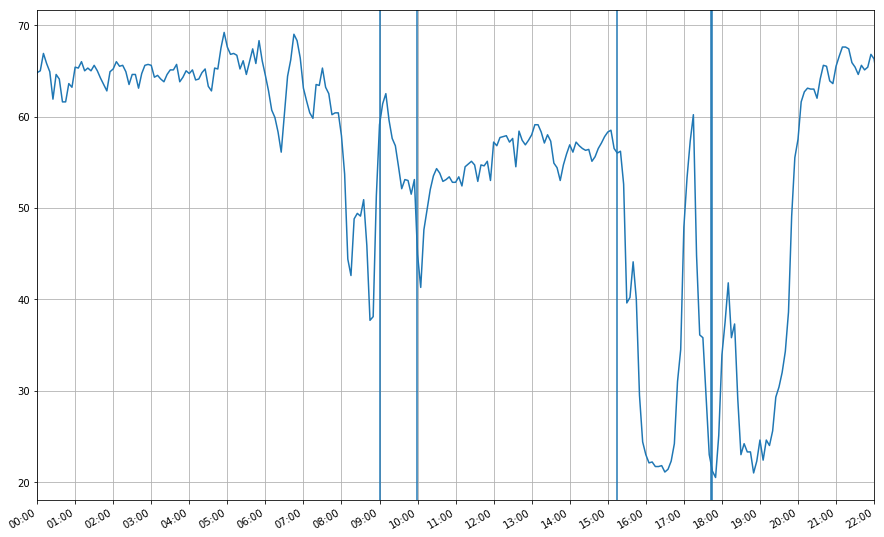

In [38]:
plot_station_data_w_nearest_incds(data_srs_no_null, data_inc_d07, stations_active, 717459, vicinity_km=3)

##  Analysis of incidents impact

In [39]:
def isImpacted(srs, ts, ticks_to_count=3, slowing_coef = .66):
    srs_b4 = srs[srs['Timestamp'] < ts].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    srs_after = srs[srs['Timestamp'] > ts].sort_values(by='Timestamp', ascending=True).iloc[:ticks_to_count]
    if(slowing_coef * srs_b4['Avg Speed'].mean() > srs_after['Avg Speed'].mean()):
        return True
    return False
isImpacted_vec = np.vectorize(isImpacted, excluded=[1,2])

In [40]:
def isImpactedWithNextSt(stationID, n_stationID, srs, ts, ticks_to_count=4, slowing_coef = .9):
#     srs_b4 = srs[srs['Timestamp'] < ts].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    srs_b4 = srs[(srs['Timestamp'] < ts) & (srs['Station']==stationID)].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    n_srs_b4 = srs[(srs['Timestamp'] < ts) & (srs['Station']==n_stationID)].sort_values(by='Timestamp', ascending=True).iloc[-ticks_to_count:]
    srs_after = srs[(srs['Timestamp'] > ts) & (srs['Station']==stationID)].sort_values(by='Timestamp', ascending=True).iloc[:ticks_to_count]
    n_srs_after = srs[(srs['Timestamp'] > ts) & (srs['Station']==n_stationID)].sort_values(by='Timestamp', ascending=True).iloc[:ticks_to_count]
#     if (stationID==769405) & (n_stationID==769403):
#         print('{}\n {}'.format(srs_after[['Avg Speed', 'Timestamp']], n_srs_after[['Avg Speed', 'Timestamp']]))
#     cond1 = slowing_coef * n_srs_after['Avg Speed'].mean() > srs_after['Avg Speed'].mean()
#     cond2 = 1.1*np.abs(n_srs_b4['Avg Speed'].mean()-srs_b4['Avg Speed'].mean()) < np.abs(n_srs_after['Avg Speed'].mean()-srs_after['Avg Speed'].mean())
    cond1 = n_srs_b4['Avg Speed'].as_matrix().dot(srs_b4['Avg Speed'].as_matrix())
    cond2 = n_srs_after['Avg Speed'].as_matrix().dot(srs_after['Avg Speed'].as_matrix())
    cond3 = slowing_coef*n_srs_after['Avg Speed'].mean() > srs_after['Avg Speed'].mean()
#     print('{} {}'.format(slowing_coef*cond1 , cond2))
#     print('{} {}'.format(n_srs_b4['Avg Speed'].as_matrix() , srs_b4['Avg Speed'].as_matrix()))
#     print('{} {}'.format(n_srs_after['Avg Speed'].as_matrix() , srs_after['Avg Speed'].as_matrix()))
#     print('{} {}'.format(n_srs_b4['Timestamp'].as_matrix() , srs_b4['Timestamp'].as_matrix()))
#     print('{} {}'.format(n_srs_after['Timestamp'].as_matrix() , srs_after['Timestamp'].as_matrix()))
    if slowing_coef*cond1 > cond2 and cond3: 
        return True
    return False

In [41]:
isImpactedWithNextSt(stID, 769405,  data_srs_smoothed, data_inc_d07[data_inc_d07.IncidentID == 17521284].Timestamp.iloc[0])

NameError: name 'stID' is not defined

In [42]:
def return_station_series(srs, station):
    return srs[srs['Station']==station]
return_station_series_vec = np.vectorize(return_station_series, excluded=[0])

In [43]:
tinc = data_inc_d07.iloc[6]

In [44]:
tst = stations_active[stations_active['Dir'] == tinc['Freeway_direction']]

In [45]:
def filter_proper_direction(incident, stations):
    target_stations = stations[stations['Dir']==incident['Freeway_direction']]
    if incident['Freeway_direction'] == 'N':
        target_stations = target_stations[target_stations['Latitude']<incident['Latitude']]
    elif incident['Freeway_direction'] == 'E':
        target_stations = target_stations[target_stations['Longitude']<incident['Longitude']]
    elif incident['Freeway_direction'] == 'S':
        target_stations = target_stations[target_stations['Latitude']>incident['Latitude']]
    elif incident['Freeway_direction'] == 'W':
        target_stations = target_stations[target_stations['Longitude']>incident['Longitude']]
    return target_stations

In [89]:
def isDownstream(incident, station):
#     target_stations = stations[stations['Dir']==incident['Freeway_direction']]
#     cond_fwy_match = incident['Freeway'] == station['Fwy']
    if incident['Freeway_direction'] == 'N':
        return station['Latitude']<incident['Latitude'] #and cond_fwy_match
    elif incident['Freeway_direction'] == 'E':
        return station['Longitude']<incident['Longitude'] #and cond_fwy_match
    elif incident['Freeway_direction'] == 'S':
        return station['Latitude']>incident['Latitude'] #and cond_fwy_match
    elif incident['Freeway_direction'] == 'W':
        return station['Longitude']>incident['Longitude'] #and cond_fwy_match
    return False

In [88]:
def isUpstream(incident, station):
#     target_stations = stations[stations['Dir']==incident['Freeway_direction']]
    if incident['Freeway_direction'] == 'N':
        return station['Latitude']>incident['Latitude']
    elif incident['Freeway_direction'] == 'E':
        return station['Longitude']>incident['Longitude']
    elif incident['Freeway_direction'] == 'S':
        return station['Latitude']<incident['Latitude']
    elif incident['Freeway_direction'] == 'W':
        return station['Longitude']<incident['Longitude']
    return False

In [48]:
def get_next_downstream_station(stations, stationID, incidents, incidentID, correction=.002):
    meta = stations[stations.ID==stationID].iloc[0][['Fwy', 'Dir', 'Latitude', 'Longitude']]
    candidates = stations[(stations['Fwy']==meta[0])&(stations['Dir']==meta[1])].drop(stations.columns[-4:], axis=1).copy()
    if meta[1] == 'S':
        candidates.loc[:,'Distance'] = meta[-2] - candidates['Latitude']
        cond1 = candidates['Latitude'] < incidents[incidents['IncidentID']==incidentID].iloc[0]['Latitude'] - correction
    elif meta[1] == 'N':
        candidates.loc[:,'Distance'] = candidates['Latitude'] - meta[-2]
        cond1 = candidates['Latitude'] > incidents[incidents['IncidentID']==incidentID].iloc[0]['Latitude'] + correction
    elif meta[1] == 'W':
        candidates.loc[:,'Distance'] = meta[-1] - candidates['Longitude']
        cond1 = candidates['Longitude'] < incidents[incidents['IncidentID']==incidentID].iloc[0]['Longitude'] - correction
    else : # meta[1] == 'E':
        candidates.loc[:,'Distance'] = candidates['Longitude'] - meta[-1]
        cond1 = candidates['Longitude'] > incidents[incidents['IncidentID']==incidentID].iloc[0]['Longitude'] + correction
    cond2 = (np.abs(candidates['Distance'])<0.025)
#     print(incidents[incidents['IncidentID']==incidentID].iloc[0])
    return candidates[cond1 & cond2 & (candidates['Distance'] > 0)].sort_values(['Distance']).reset_index(drop=True)

In [49]:
def get_neighbouring_station(stations, stationID):
    meta = stations[stations.ID==stationID].iloc[0][['Fwy', 'Dir', 'Latitude', 'Longitude']]
    candidates = stations[(stations['Fwy']==meta[0])&(stations['Dir']==meta[1])].drop(stations.columns[-4:], axis=1).copy()
    if meta[1] == 'S':
        candidates.loc[:,'Distance'] = meta[-2] - candidates['Latitude']
#         cond = 
    elif meta[1] == 'N':
        candidates.loc[:,'Distance'] = candidates['Latitude'] - meta[-2]
    elif meta[1] == 'W':
        candidates.loc[:,'Distance'] = meta[-1] - candidates['Longitude']
    else : # meta[1] == 'E':
        candidates.loc[:,'Distance'] = candidates['Longitude'] - meta[-1]
    cond2 = (np.abs(candidates['Distance'])<0.020)
    return candidates[cond2].sort_values(['Distance']).reset_index(drop=True)

In [909]:
get_next_downstream_station(stations_active,717486,data_inc_d07,17521284)

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,Distance


In [52]:
def plot_drctn_station_data_w_nearest_incds(flow_data, incdnt_data, stations_data, station_no, vicinity_km, chrstc_to_plot = 'Avg Speed'):
    hours = mdts.HourLocator()
    datemin = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=4)
    datemax = dt.datetime(year=incdnt_data.Timestamp.dt.year[0], month=incdnt_data.Timestamp.dt.month[0], day=incdnt_data.Timestamp.dt.day[0], hour=22)
    # filter only data for one station and w/o nans
    data_srs_no_null = flow_data[flow_data['Station'] == station_no]
    data_srs_no_null = data_srs_no_null.dropna(subset=[chrstc_to_plot])
    # station of interest coords
    station_coords = np.asarray(stations_data[stations_data['ID'] == station_no][['Latitude', 'Longitude']])
    # incidents closest to the station
    data_incdnts_nearest = incdnt_data[incdnt_data.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), station_coords).kilometers < vicinity_km, axis=1)]
    # x-values
    dates = data_srs_no_null['Timestamp']
    # y-values
    speed = data_srs_no_null[chrstc_to_plot]
    fig,ax = plt.subplots(figsize=[15,10])
    fig.figsize = [15,10]
    plt.plot_date(dates, speed, fmt='-', tz='EST')
    for index,x in data_incdnts_nearest.iterrows():
        if isDownstream(x, stations_data[stations_data['ID'] == station_no].iloc[0]):
            plt.axvline(x['Timestamp'])
    ax.xaxis.set_major_locator(hours)
    fig.autofmt_xdate()
    ax.xaxis.set_major_formatter(mdts.DateFormatter('%H:%M'))
    ax.set_xlim(datemin, datemax)
    plt.grid()
    plt.show()

In [53]:
def get_distance_acc_to_sens(stations, ID, accidents, aID):
    return vincenty(list(accidents[accidents.IncidentID==aID][['Latitude', 'Longitude']].iloc[0]), list(stations[stations.ID==ID][['Latitude', 'Longitude']].iloc[0])).kilometers

In [54]:
def get_stations_within_inc_vicinity(incident, stations, vicinity):
    inc_loc = np.asarray(incident[['Latitude', 'Longitude']])
    return stations[stations.apply(lambda x: vincenty((x['Latitude'], x['Longitude']), inc_loc).kilometers < vicinity, axis=1)]

In [55]:
ttst = get_stations_within_inc_vicinity(tinc, stations_active,1)

In [56]:
def calculate_affect_degree(incidents, series, stations, radius):
    impact = np.array([])
    for crnt_inc in incidents.iterrows():
        target_stations = filter_proper_direction(crnt_inc[1], stations)
        if target_stations.size == 0:
            impact = np.append(impact,-1.0)
            continue
        crnt_vcnt_st = get_stations_within_inc_vicinity(crnt_inc[1], target_stations, radius)  
        if crnt_vcnt_st.size == 0:
            impact = np.append(impact,-1.0)
            continue
        series_in_quest = return_station_series_vec(series, crnt_vcnt_st['ID'])
        impacted_result = isImpacted_vec(series_in_quest, crnt_inc[1]['Timestamp'], 3)
        prcnt = impacted_result.sum()/impacted_result.shape[0]
        impact = np.append(impact,prcnt)
    return impact

In [57]:
impact_km = calculate_affect_degree(data_inc_d07.iloc[:20], data_srs_no_null, stations_active, 4)

In [58]:
impact_km = impact_km[impact_km != -1.0]

In [59]:
impact_3km_htgrm = np.histogram(impact_km)

In [60]:
tst = tst[tst['Latitude']>tinc['Latitude']]

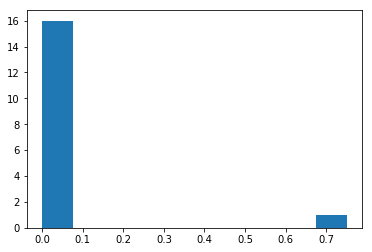

In [61]:
plt.hist(impact_km)
plt.show()

In [62]:
def plot_impact_of_distance(d_range, bins, incidents, series, stations):
    mean_array = np.array([])
    fig, axes = plt.subplots(2, int(bins/2), figsize=[15,7])
    i=0
    for d in np.linspace(d_range[0], d_range[1], bins):
        impact = calculate_affect_degree(incidents, series, stations, d)
        impact = impact[impact != -1.0]
        mean_array = np.append(mean_array, impact.mean())
        axes[int(2*i/bins)][int(i%(bins/2))].hist(impact)
        axes[int(2*i/bins)][int(i%(bins/2))].set_title('{:.3f}'.format(d))
        i += 1
    plt.show()
    return mean_array

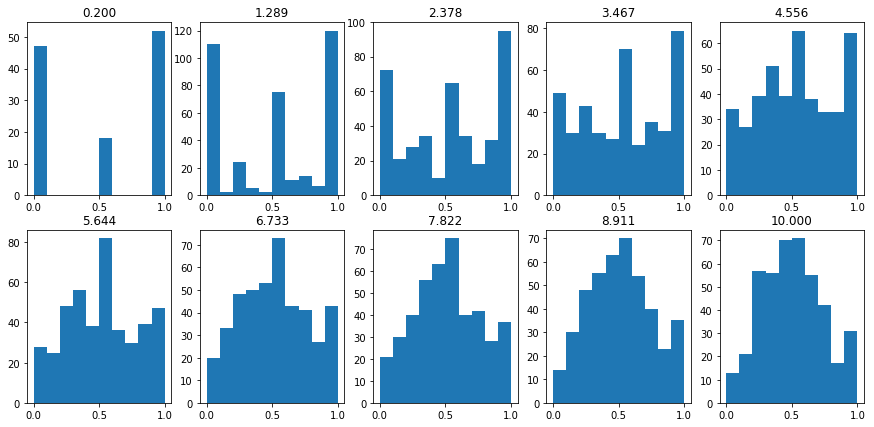

In [41]:
m_ar = plot_impact_of_distance([.2, 10], 10, data_inc_d07, data_srs_smoothed, stations_active)

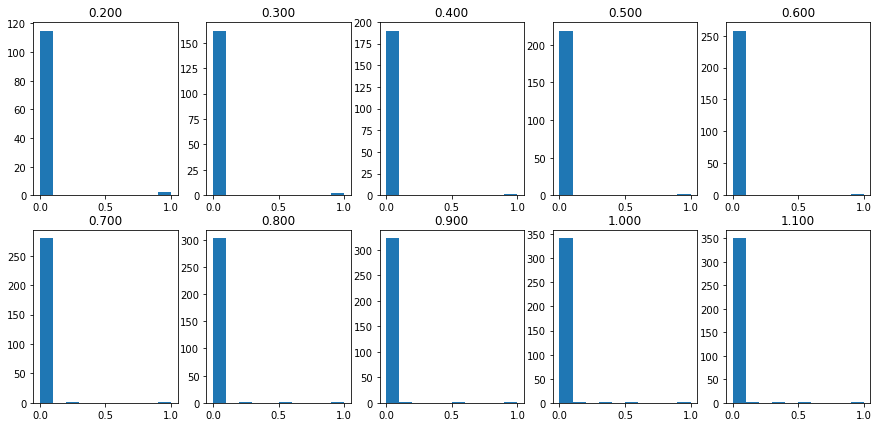

In [87]:
m_ar = plot_impact_of_distance([.2, 1.1], 10, data_inc_d07, data_srs_smoothed, stations_active)

Hot spot station analysis

In [279]:
def data_construction(incidents, stations, series, vicinity=3, averaged_span=4):
    limit_count = 20 #  yields more by one
    counter = 0
    features_count = 11
#     iter_no = 0 
    dataset = np.empty((1,features_count))
#     dataset = np.append(dataset, np.ones((1,1)), axis=0)
    for index,an_inc in incidents.iterrows():
        for stindex, a_station in stations.iterrows(): #get_stations_within_inc_vicinity(incident=an_inc, stations=stations, vicinity=vicinity).iterrows():
            distance = vincenty((an_inc['Latitude'], an_inc['Longitude']), (a_station['Latitude'], a_station['Longitude'])).kilometers
            if distance < vicinity:
#                 print(a_station)

                incID = an_inc['IncidentID']
                stID = a_station['ID']
                hour = an_inc.Timestamp.hour
                minute = an_inc.Timestamp.minute
                absDist = distance #vincenty((an_inc['Latitude'], an_inc['Longitude']), (a_station['Latitude'], a_station['Longitude'])).kilometers
#                 dwnstm = isDownstream(an_inc, a_station)
                dir_match = an_inc['Freeway_direction'] == a_station['Dir']
                fwy_match = an_inc['Freeway'] == a_station['Fwy']
                if fwy_match and dir_match:
                    upstm = isUpstream(an_inc, a_station) # incident is upstream to station
#                     dwnstm = isDownstream(an_inc, a_station)
                else:
                    upstm = 0
#                     dwnstm = 0
                mean_spd_b4 = series[(series['Timestamp'] < an_inc['Timestamp']) & (series['Station'] == stID)].sort_values(by='Timestamp', ascending=True)['Avg Speed'].iloc[-averaged_span:].mean()
                lanes_count = a_station["Lanes"]
                dwnstrm_st = get_next_downstream_station(stationID=stID, stations=stations, incidents=incidents, incidentID=incID)
                if dwnstrm_st.shape[0] > 0:
                    y = isImpactedWithNextSt(stID, dwnstrm_st.iloc[0]['ID'], series, an_inc['Timestamp'])
#                     if incID == 17521281:
# #                         print('got')
#                         print('{} {} {} {}'.format(stID, dwnstrm_st.iloc[0]['ID'], an_inc['Timestamp'], y))
                else:
                    y = isImpacted(srs=series[series['Station'] == stID], ts=an_inc['Timestamp'] )
                features = np.array([incID, stID, hour, minute, absDist, dir_match, fwy_match, upstm, mean_spd_b4, lanes_count, y]).reshape(1, features_count)
#                 print(type(stID))
                dataset = np.append(dataset, features, axis=0)
#             iter_no += 1
#         if counter >= limit_count:
#             break
        counter += 1
    return dataset[1:]

In [342]:
for day in range(9,14,1):
    srs_fname = '../data/PeMS/Series/smoothed/d07_text_station_5min_2017_10_{:02d}.csv'
    inc_fname = '../data/PeMS/Incidents/light/all_text_chp_incident_day_2017_10_{:02d}.csv'
    impact_fname = '../data/PeMS/Incidents/logit/impact_2017_10_{:02d}.csv'
    d_srs_smoothed = pd.read_csv(srs_fname.format(day), parse_dates=[0])
    d_inc = pd.read_csv(inc_fname.format(day), parse_dates=[3])
    pairs_ds = data_construction(d_inc,stations_active, d_srs_smoothed)
    np.savetxt(impact_fname.format(day), pairs_ds, delimiter=',', header=', '.join(['IncidentID', 'StationID', 'Hour', 'Minute', 'Distance', 'DirMatch', 'FwyMatch', 'isUpstream', 'MeanSpeed', 'Lanes', 'y']))

In [282]:
(pairs_ds[:,-1]==0).sum()

16426

In [265]:
pairs_ds = data_construction(d_inc,stations_active, d_srs_smoothed)

In [181]:
np.savetxt('../data/PeMS/Incidents/logit/impact_2017_10_11.csv', pairs_ds, delimiter=',', header=', '.join(['IncidentID', 'StationID', 'Hour', 'Minute', 'Distance', 'DirMatch', 'FwyMatch', 'isUpstream', 'MeanSpeed', 'Lanes', 'y']))

In [171]:
sum(pairs_ds[:,-1]==1)

728

In [170]:
sum(pairs_ds[:,-1]==1)/pairs_ds.shape[0]

0.048990578734858681

In [70]:
imp_pairs = pairs_ds[(pairs_ds[:,3] == 1) & (pairs_ds[:,5] == 1)]

In [71]:
rel = np.histogram(imp_pairs[:,2], bins=40)[0]/np.histogram(pairs_ds[:,2], bins=40)[0]

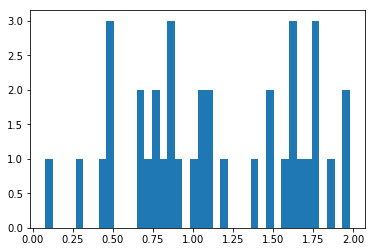

In [72]:
plt.hist(imp_pairs[:,2], bins=40)
plt.show()

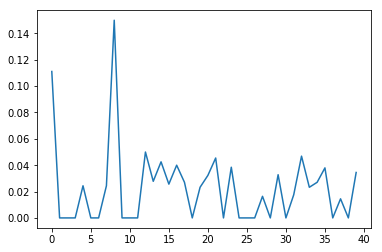

In [73]:
plt.plot(rel)
plt.show()

In [267]:
d_inc[d_inc.IncidentID.isin(pairs_ds[pairs_ds[:,-1]==1][:,0])]

,IncidentID,CC_Code,Incident_No,Timestamp,Description,Location,Area,Zoom_Map,TBxy,Latitude,Longitude,District,CountryFIPS_ID,CityFIPS_ID,Freeway,Freeway_direction,State_postmile,Absolute_postmile,Severity,Duration
6,17515900,LAHB,171009,2017-10-09 00:55:00,1125-Traffic Hazard,Us101 N / Glendale Blvd,Central LA,NaN,NaN,34.069825,-118.261327,7,37.0,44000.0,101,N,2.552,3.9,NaN,41.0
12,17515965,LAHB,171009,2017-10-09 02:12:00,1125-Traffic Hazard,I10 E / Alameda St Ofr,Central LA,NaN,NaN,34.023585,-118.242864,7,37.0,44000.0,10,E,16.855,14.7,NaN,22.0
19,17515993,LAHB,171009,2017-10-09 02:58:00,SIG Alert,Sr118 E / Hayvenhurst Ave,West Valley,NaN,NaN,34.274711,-118.493422,7,37.0,44000.0,118,E,R8.369,41.9,NaN,82.0


In [268]:
incID = 17515900
pairs_ds[(pairs_ds[:,0]== incID) & (pairs_ds[:,-1]==1) & (pairs_ds[:,2]<3)][:,1]

array([ 773023.])

In [923]:
np.unique(pairs_ds[pairs_ds[:,-1]==1][:,1])[:100]

array([ 717486.,  717963.,  718045.,  718376.,  760650.,  761220.,
        764949.,  766788.,  769402.,  769405.,  772872.,  772887.])

In [269]:
stID = 773023
get_next_downstream_station(stations_active,stID,d_inc, incID)

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,Distance
0,717447,101,N,7,37,44000.0,2.94,4.288,34.072657,-118.268106,0.430,ML,4,ALVARADO,0.015684
1,717452,101,N,7,37,44000.0,3.28,4.628,34.074945,-118.273396,0.450,ML,4,RAMPART,0.017972
2,716337,101,N,7,37,44000.0,3.84,5.188,34.077518,-118.282724,0.460,ML,4,SILVER LAKE,0.020545
3,765164,101,N,7,37,44000.0,4.2,5.548,34.078907,-118.288793,0.335,ML,4,VERMONT 1,0.021934
4,717456,101,N,7,37,44000.0,4.51,5.858,34.081134,-118.293470,0.290,ML,4,VERMONT 2,0.024161


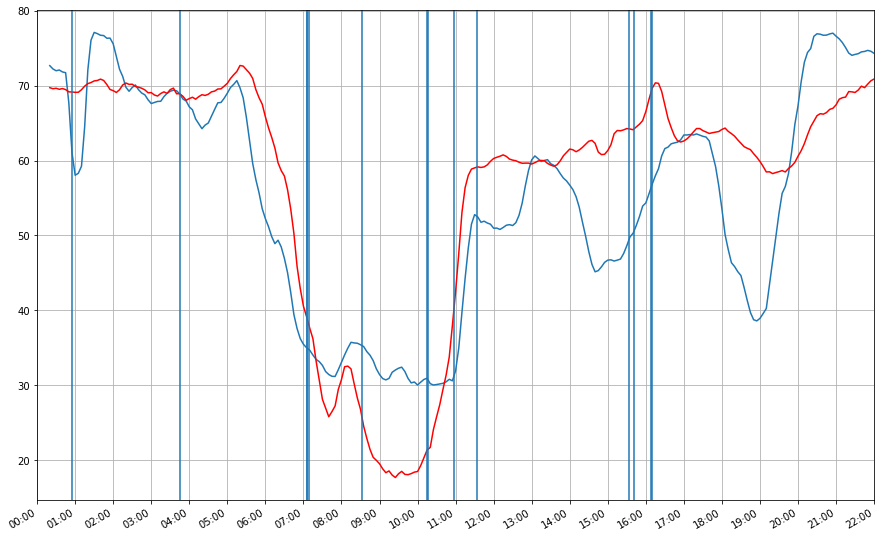

In [271]:
plot_two_station_data_w_nearest_incds(d_srs_smoothed, d_inc, stations_active, stID, 717447,vicinity_km=3, chrstc_to_plot = 'Avg Speed')

In [355]:
vrf = np.loadtxt('../data/PeMS/Incidents/logit/result/tp.csv', delimiter=',')

In [344]:
data_srs_smoothed = pd.read_csv('../data/PeMS/Series/smoothed/d07_text_station_5min_2017_10_09.csv', parse_dates=[0])

In [345]:
data_inc = pd.read_csv('../data/PeMS/Incidents/light/all_text_chp_incident_day_2017_10_09.csv', parse_dates=[3])

In [356]:
data_inc[data_inc.IncidentID.isin(vrf[:,0])]

,IncidentID,CC_Code,Incident_No,Timestamp,Description,Location,Area,Zoom_Map,TBxy,Latitude,Longitude,District,CountryFIPS_ID,CityFIPS_ID,Freeway,Freeway_direction,State_postmile,Absolute_postmile,Severity,Duration
42,17516107,LAHB,171009,2017-10-09 05:32:00,1125-Traffic Hazard,I5 S / I5 S Sr110 S Con,LAFSP,NaN,NaN,34.089130,-118.237527,7,37.0,44000.0,5,S,21.33,137.9,NaN,20.0
59,17516192,LAHB,171009,2017-10-09 06:27:00,1125-Traffic Hazard,I605 N / Imperial Hwy,LAFSP,NaN,NaN,33.917103,-118.104564,7,37.0,52526.0,605,N,R7.848,9.9,NaN,72.0
60,17516194,LAHB,171009,2017-10-09 06:25:00,1125-Traffic Hazard,Us101 S / Lankershim Blvd,Central LA,NaN,NaN,34.137630,-118.362925,7,37.0,44000.0,101,S,10.352,11.7,NaN,2.0
64,17516212,LAHB,171009,2017-10-09 06:37:00,1183-Trfc Collision-Unkn Inj,I5 S / I5 S Sr60 E Con,LAFSP,NaN,NaN,34.032606,-118.220771,7,37.0,44000.0,5,S,16.83,133.4,NaN,112.0
67,17516221,LAHB,171009,2017-10-09 06:40:00,1125-Traffic Hazard,I605 S / Valley Blvd,East LA,NaN,NaN,34.054356,-118.004333,7,37.0,NaN,605,S,R19.448,21.5,NaN,2.0
70,17516242,LAHB,171009,2017-10-09 06:53:00,1182-Trfc Collision-No Inj,Sr118 W / Rinaldi St Ofr,LAFSP,NaN,NaN,34.276481,-118.532467,7,37.0,44000.0,118,W,R6.069,39.6,NaN,22.0
74,17516252,LAHB,171009,2017-10-09 06:56:00,1182-Trfc Collision-No Inj,I110 S / Mlk,LAFSP,NaN,NaN,34.011075,-118.281251,7,37.0,44000.0,110,S,19.47,19.4,NaN,9.0
75,17516253,LAHB,171009,2017-10-09 06:55:00,1182-Trfc Collision-No Inj,I110 S / Mlk,Central LA,NaN,NaN,34.011075,-118.281251,7,37.0,44000.0,110,S,19.47,19.4,NaN,7.0
77,17516269,LAHB,171009,2017-10-09 07:09:00,1182-Trfc Collision-No Inj,I5 N 4th St Ofr / E 4th St,LAFSP,NaN,NaN,34.042795,-118.216653,7,37.0,44000.0,5,N,17.567,134.2,NaN,26.0
79,17516271,LAHB,171009,2017-10-09 07:05:00,1183-Trfc Collision-Unkn Inj,I10 W / S Boyle Ave,Central LA,NaN,NaN,34.038583,-118.219771,7,37.0,44000.0,10,W,18.355,16.2,NaN,28.0


In [358]:
incID = 17517525
vrf[:,1][vrf[:,0]==incID]

array([ 775636.,  774671.])

In [359]:
stID = 775636
get_next_downstream_station(stations_active,stID,data_inc, incID)

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,Distance
0,764037,110,S,7,37,44000.0,20.6,20.53,34.026164,-118.275402,0.500,ML,5,ADAMS,0.005675
1,763447,110,S,7,37,44000.0,20,19.93,34.018314,-118.280127,0.400,ML,5,EXPOSITION2,0.013525
2,763246,110,S,7,37,44000.0,19.8,19.73,34.015503,-118.281106,0.315,ML,4,EXPOSITION1,0.016336
3,718041,110,S,7,37,44000.0,19.37,19.30,34.009215,-118.281288,0.455,ML,5,KING BLVD,0.022624


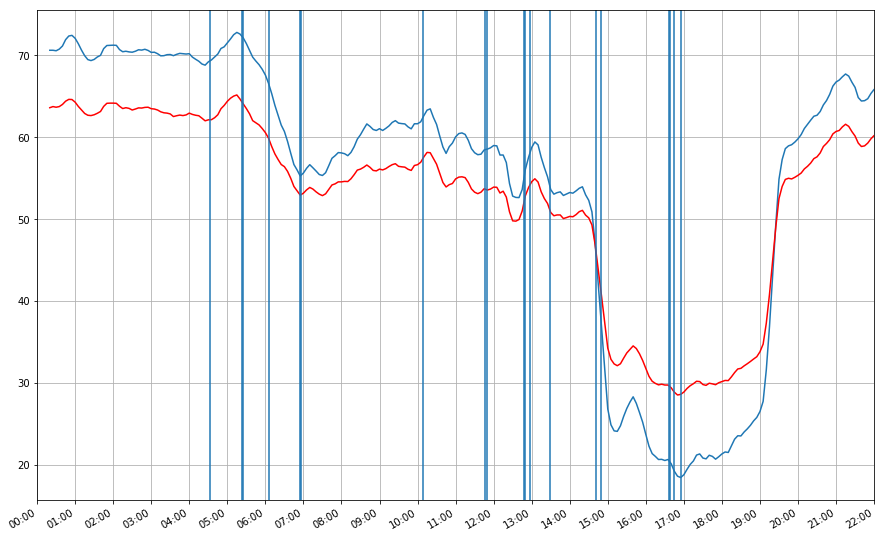

In [360]:
plot_two_station_data_w_nearest_incds(data_srs_smoothed, data_inc, stations_active, stID, 764037,vicinity_km=3, chrstc_to_plot = 'Avg Speed')

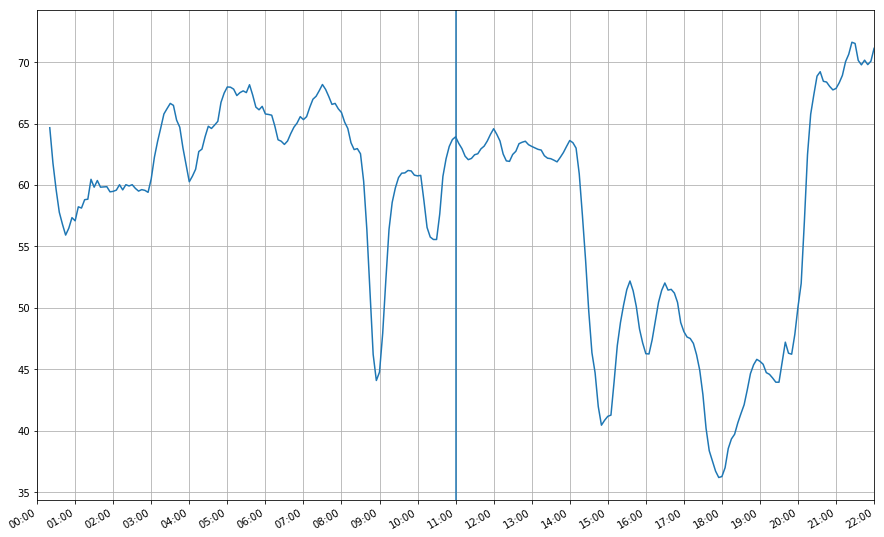

In [160]:
plot_station_data_w_nearest_incds(data_srs_smoothed, data_inc_d07, stations_active, 717635, vicinity_km=2, chrstc_to_plot = 'Avg Speed')